In [ ]:
# default_exp helper_functions

# helper_functions

> read and preprocess netcdf data

In [ ]:
from nbdev import *
from drcstools.helper_functions import *

In [ ]:
#export
import xarray as xr
import numpy as np
from glob import glob

In [ ]:
#export
def rotated_grid_transform(grid_in, option, SP_coor):
    """
    rotated pole
    """

    pi = np.pi
    lon = grid_in[0]
    lat = grid_in[1];

    lon = (lon*pi)/180; # Convert degrees to radians
    lat = (lat*pi)/180;

    SP_lon = SP_coor[0];
    SP_lat = SP_coor[1];

    SP_lon = SP_lon - 180
    SP_lat = -SP_lat

    theta = 90+SP_lat; # Rotation around y-axis
    phi = SP_lon; # Rotation around z-axis

    theta = (theta*pi)/180;
    phi = (phi*pi)/180; # Convert degrees to radians

    x = np.cos(lon)*np.cos(lat); # Convert from spherical to cartesian coordinates
    y = np.sin(lon)*np.cos(lat);
    z = np.sin(lat);

    if option == 1: # Regular -> Rotated

        x_new = np.cos(theta)*np.cos(phi)*x + np.cos(theta)*np.sin(phi)*y + np.sin(theta)*z;
        y_new = -np.sin(phi)*x + np.cos(phi)*y;
        z_new = -np.sin(theta)*np.cos(phi)*x - np.sin(theta)*np.sin(phi)*y + np.cos(theta)*z;

    else:  # Rotated -> Regular

        phi = -phi;
        theta = -theta;

        x_new = np.cos(theta)*np.cos(phi)*x + np.sin(phi)*y + np.sin(theta)*np.cos(phi)*z;
        y_new = -np.cos(theta)*np.sin(phi)*x + np.cos(phi)*y - np.sin(theta)*np.sin(phi)*z;
        z_new = -np.sin(theta)*x + np.cos(theta)*z;

    lon_new = np.arctan2(y_new,x_new); # Convert cartesian back to spherical coordinates
    lat_new = np.arcsin(z_new);

    lon_new = (lon_new*180)/pi; # Convert radians back to degrees
    lat_new = (lat_new*180)/pi;

    return lon_new , lat_new

In [ ]:
#export
def adjust_lon_lat(ds, lon_name, lat_name, reverse = False):
    """Adjusts longitude from 0 to 360 to -180 to 180 and reverses latitude."""

    if reverse == True:
        ds = ds.reindex({lat_name:ds[lat_name][::-1]})

    ds['_longitude_adjusted'] = xr.where(
        ds[lon_name] > 180,
        ds[lon_name] - 360,
        ds[lon_name])

    ds = (ds
          .swap_dims({lon_name: '_longitude_adjusted'})
          .sel(**{'_longitude_adjusted': sorted(ds._longitude_adjusted)})
          .drop(lon_name))

    ds = ds.rename({'_longitude_adjusted': lon_name})

    return ds

In [ ]:
show_doc(adjust_lon_lat)

<h4 id="adjust_lon_lat" class="doc_header"><code>adjust_lon_lat</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>adjust_lon_lat</code>(**`ds`**, **`lon_name`**, **`lat_name`**, **`reverse`**=*`False`*)

Adjusts longitude from 0 to 360 to -180 to 180 and reverses latitude.

Args:
- ds (xarray): xarray Dataset
- lon_name (str): name of longitude in ds
- lat_name (str): name of latitude in ds 
- reverse (bool): if True latitude is reversed

Returns: 
- ds (xarray)  

In [ ]:
#export
def guess_bounds(points, bound_position=0.5):
    """
    Guess bounds of grid cells.

    Simplified function from iris.coord.Coord.

    Parameters
    ----------
    points: numpy.array
        Array of grid points of shape (N,).
    bound_position: float, optional
        Bounds offset relative to the grid cell centre.
    Returns
    -------
    Array of shape (N, 2).
    """
    diffs = np.diff(points)
    diffs = np.insert(diffs, 0, diffs[0])
    diffs = np.append(diffs, diffs[-1])

    min_bounds = points - diffs[:-1] * bound_position
    max_bounds = points + diffs[1:] * (1 - bound_position)

    return np.array([min_bounds, max_bounds]).transpose()

In [ ]:
show_doc(guess_bounds)

<h4 id="guess_bounds" class="doc_header"><code>guess_bounds</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>guess_bounds</code>(**`points`**, **`bound_position`**=*`0.5`*)

Guess bounds of grid cells.

Simplified function from iris.coord.Coord.

Parameters
----------
points: numpy.array
    Array of grid points of shape (N,).
bound_position: float, optional
    Bounds offset relative to the grid cell centre.
Returns
-------
Array of shape (N, 2).

In [ ]:
#export
def quadrant_area(radian_lat_bounds, radian_lon_bounds, radius_of_earth):
    """
    Calculate spherical segment areas.
    Taken from SciTools iris library.
    Area weights are calculated for each lat/lon cell as:
        .. math::
            r^2 (lon_1 - lon_0) ( sin(lat_1) - sin(lat_0))
    The resulting array will have a shape of
    *(radian_lat_bounds.shape[0], radian_lon_bounds.shape[0])*
    The calculations are done at 64 bit precision and the returned array
    will be of type numpy.float64.
    Parameters
    ----------
    radian_lat_bounds: numpy.array
        Array of latitude bounds (radians) of shape (M, 2)
    radian_lon_bounds: numpy.array
        Array of longitude bounds (radians) of shape (N, 2)
    radius_of_earth: float
        Radius of the Earth (currently assumed spherical)
    Returns
    -------
    Array of grid cell areas of shape (M, N).
    """
    # ensure pairs of bounds
    if (
        radian_lat_bounds.shape[-1] != 2
        or radian_lon_bounds.shape[-1] != 2
        or radian_lat_bounds.ndim != 2
        or radian_lon_bounds.ndim != 2
    ):
        raise ValueError("Bounds must be [n,2] array")

    # fill in a new array of areas
    radius_sqr = radius_of_earth ** 2
    radian_lat_64 = radian_lat_bounds.astype(np.float64)
    radian_lon_64 = radian_lon_bounds.astype(np.float64)

    ylen = np.sin(radian_lat_64[:, 1]) - np.sin(radian_lat_64[:, 0])
    xlen = radian_lon_64[:, 1] - radian_lon_64[:, 0]
    areas = radius_sqr * np.outer(ylen, xlen)

    # we use abs because backwards bounds (min > max) give negative areas.
    return np.abs(areas)

In [ ]:
show_doc(quadrant_area)

<h4 id="quadrant_area" class="doc_header"><code>quadrant_area</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>quadrant_area</code>(**`radian_lat_bounds`**, **`radian_lon_bounds`**, **`radius_of_earth`**)

Calculate spherical segment areas.
Taken from SciTools iris library.
Area weights are calculated for each lat/lon cell as:
    .. math::
        r^2 (lon_1 - lon_0) ( sin(lat_1) - sin(lat_0))
The resulting array will have a shape of
*(radian_lat_bounds.shape[0], radian_lon_bounds.shape[0])*
The calculations are done at 64 bit precision and the returned array
will be of type numpy.float64.
Parameters
----------
radian_lat_bounds: numpy.array
    Array of latitude bounds (radians) of shape (M, 2)
radian_lon_bounds: numpy.array
    Array of longitude bounds (radians) of shape (N, 2)
radius_of_earth: float
    Radius of the Earth (currently assumed spherical)
Returns
-------
Array of grid cell areas of shape (M, N).

In [ ]:
#export
def grid_cell_areas(lon1d, lat1d, radius=6371000.0):
    """
    Calculate grid cell areas given 1D arrays of longitudes and latitudes
    for a planet with the given radius.

    Parameters
    ----------
    lon1d: numpy.array
        Array of longitude points [degrees] of shape (M,)
    lat1d: numpy.array
        Array of latitude points [degrees] of shape (M,)
    radius: float, optional
        Radius of the planet [metres] (currently assumed spherical)
    Returns
    -------
    Array of grid cell areas [metres**2] of shape (M, N).
    """
    lon_bounds_radian = np.deg2rad(guess_bounds(lon1d))
    lat_bounds_radian = np.deg2rad(guess_bounds(lat1d))
    area = quadrant_area(lat_bounds_radian, lon_bounds_radian, radius)
    return area

In [ ]:
show_doc(grid_cell_areas)

<h4 id="grid_cell_areas" class="doc_header"><code>grid_cell_areas</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>grid_cell_areas</code>(**`lon1d`**, **`lat1d`**, **`radius`**=*`6371000.0`*)

Calculate grid cell areas given 1D arrays of longitudes and latitudes
for a planet with the given radius.

Parameters
----------
lon1d: numpy.array
    Array of longitude points [degrees] of shape (M,)
lat1d: numpy.array
    Array of latitude points [degrees] of shape (M,)
radius: float, optional
    Radius of the planet [metres] (currently assumed spherical)
Returns
-------
Array of grid cell areas [metres**2] of shape (M, N).

In [ ]:
import xarray
ds = xr.open_dataset("data/era5.nc", use_cftime = True).isel(time = slice(0,2))

In [ ]:
lons = ds.longitude.values
lats = ds.latitude.values

In [ ]:
area_t = grid_cell_areas(lon1d = lons, lat1d = lats)

In [ ]:
ds['area_t'] = (("latitude", "longitude"), area_t)

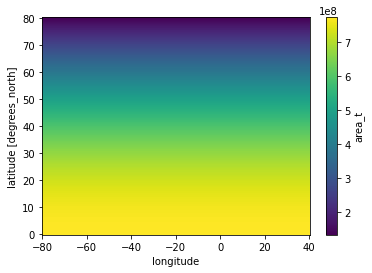

In [ ]:
ds.area_t.plot()